## 2D Spectra 

This notebook expands the analysis of the vertical and horizontal spectra, estimating the 2D spectra of along isopycnal tracers. 

We do the analysis in isopycnal space for the horizontal, and use the mean depth of the isopycnal as the vertical coordinate. 

This has a few things:
- removes IW signals for tracers. If we did horizontal vs Z, we would just end up seeing the properties of the IWs (which are highly aliased). 
- Flattening isopycnals for the mesoscale is a bit in line with QG theory, plus it is unlikely that this makes much of a difference to the signal we are thinking about here. 


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [6]:
import extra_funcs as ef

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 8

In [3]:
ds_659_rho = xr.open_dataset('../data/sg_659_iso_grid.nc')
ds_660_rho = xr.open_dataset('../data/sg_660_iso_grid.nc')

In [4]:
# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha_659 = gsw.alpha(ds_659_rho.SA, ds_659_rho.CT, ds_659_rho.ctd_pressure)
alpha_660 = gsw.alpha(ds_660_rho.SA, ds_660_rho.CT, ds_660_rho.ctd_pressure)

# remove a mean per isopycnal
dCT = ds_659_rho.CT  - ds_659_rho.CT.mean('dives')
dSA = ds_659_rho.SA - ds_659_rho.SA.mean('dives')

ds_659_rho['Spice'] = (2*alpha_659*dCT).rename('Spice')

# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (2*alpha_660*dCT ).rename('Spice')

When computing the spectra in vertical coordinate we did rescaling of the vertical coordinate from Z to Z_tilde, where the rescaling when like N/f. This was based on Smith and Ferrari 09, which showed that the spectra are isotropic in this rescaled space. So essentially we were trying to use the vertical spectra to guess the horizontal spectra, assuming that the QG scaling holds. 
Here instead when we estimate the 2D spectra directly, we try to estimate what is actually going on rather than trying to use the QG hypothesis. The result can then be checked for isotropy etc. 


### Frequency-depth wavenumber spectra

In [7]:
%%time
ds_659_time = xr.merge([ef.interp_time_rho(ds_659_rho,'ctd_pressure'),
                        ef.interp_time_rho(ds_659_rho,'Spice'),
                        ef.interp_time_rho(ds_659_rho,'CT'),
                        ef.interp_time_rho(ds_659_rho,'SA')])

ds_660_time = xr.merge([ef.interp_time_rho(ds_660_rho,'ctd_pressure'),
                        ef.interp_time_rho(ds_660_rho,'Spice'),
                        ef.interp_time_rho(ds_660_rho,'CT'),
                        ef.interp_time_rho(ds_660_rho,'SA')])

CPU times: user 27.5 s, sys: 1.38 s, total: 28.8 s
Wall time: 29.2 s


In [10]:
Pmean_smooth_dives = ds_660_rho.ctd_pressure.mean('dives').rolling(rho_grid= 30, center=True).mean()
Pmean_smooth_time  = ds_660_time.ctd_pressure.mean('days').rolling(rho_grid= 30, center=True).mean()
# the smoothing using rolling is done to remove any overturns in the mean

# ds_660_time.ctd_pressure.mean('days').plot(label='Time mean')
# Pmean_smooth_dives.plot(label='Dive mean (no time int)')
# Pmean_smooth_time.plot(label = 'Time mean')
# plt.grid()

# plt.legend()

In [13]:
# Function that regrids a single dive 
# Will be run in a loop to do interpolation for all dives.

import scipy.interpolate as interpolate

def func_var_int_pmean(ds, Pmean_smooth_time): 
    Pmean_grid = np.linspace(0,1000,501)
    
    Pmean = Pmean_smooth_time
 
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    Pmean_nonan = Pmean.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'days'],
                        coords = {'Pmean': Pmean_grid, 'days': [ds.days.values]})
    

In [24]:
# For 659 
time_ind = 0

Pmean_smooth_time = (ds_659_time.ctd_pressure.mean('days').rolling(rho_grid= 30, center=True).mean()).sel(rho_grid=slice(27.2, 27.69))
spice_on_Pmean_659 = func_var_int_pmean(ds_659_time.Spice.isel(days=0), Pmean_smooth_time)

for time_ind in range(1, len(ds_659_time.days)):
    if np.mod(time_ind, 400)==0:
        print(time_ind)
    spice_on_Pmean_659 = xr.concat([spice_on_Pmean_659, 
                                func_var_int_pmean(ds_659_time.Spice.isel(days=time_ind), Pmean_smooth_time)],
                                dim='days')

400
800
1200
1600
2000


In [25]:
# For 660 
time_ind = 0

Pmean_smooth_time = ds_660_time.ctd_pressure.mean('days').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.69))
spice_on_Pmean_660 = func_var_int_pmean(ds_660_time.Spice.isel(days=0), Pmean_smooth_time)

for time_ind in range(1, len(ds_660_time.days)):
    if np.mod(time_ind, 400)==0:
        print(time_ind)
    spice_on_Pmean_660 = xr.concat([spice_on_Pmean_660, 
                                func_var_int_pmean(ds_660_time.Spice.isel(days=time_ind), Pmean_smooth_time)],
                                dim='days')

400
800
1200
1600
2000


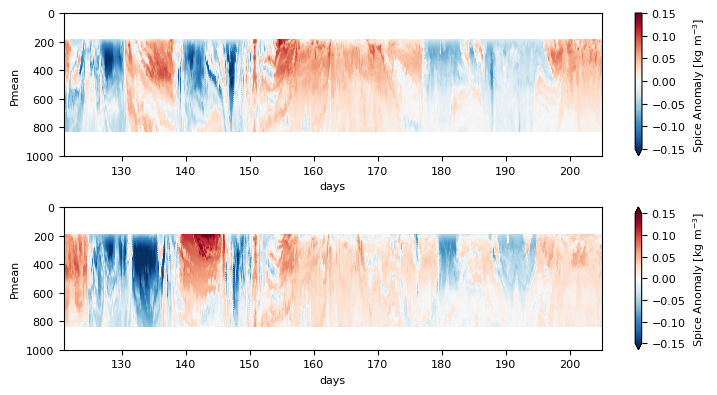

In [26]:
plt.figure(figsize=(7.5,4.))


plt.subplot(211)
(1000*spice_on_Pmean_659).plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.gca().invert_yaxis()

#plt.ylim([800, 180]) # this is the range that is not super influenced by interplation.

plt.subplot(212)
(1000*spice_on_Pmean_660).plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.gca().invert_yaxis()

plt.tight_layout()

In [43]:
# Now we have the section that we will use to do the spectral calc on.

In [27]:
spice_659_2d_ps =xrft.power_spectrum(spice_on_Pmean_659.sel(Pmean=slice(200, 800)).isel(days=slice(0,2000)).chunk({'days':400}), dim=['Pmean', 'days'],
                                window=True, chunks_to_segments=True)

spice_660_2d_ps =xrft.power_spectrum(spice_on_Pmean_660.sel(Pmean=slice(200, 800)).isel(days=slice(0,2000)).chunk({'days':400}), dim=['Pmean', 'days'],
                                window=True, chunks_to_segments=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [29]:
spice_2d_ps = 0.5*(spice_659_2d_ps + spice_660_2d_ps)

In [31]:
import matplotlib.colors as colors

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/plot/plot.py:1426: UserWarning: Log scale: values of z <= 0 have been masked
  primitive = ax.contourf(x, y, z, **kwargs)


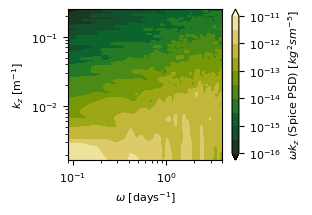

In [90]:
plt.figure(figsize=(3.1, 2.2))

m = spice_2d_ps.freq_Pmean
k = spice_2d_ps.freq_days

lev_exp = np.linspace(-16, -11, 11)
levs = np.power(10, lev_exp)

cnt = (np.abs(m)*np.abs(k)*spice_2d_ps.mean(['Pmean_segment', 'days_segment'])).plot.contourf(
                        levels=levs,
                      norm=colors.LogNorm(vmin=1e-16),
                        cmap=cmo.speed_r, 
                     cbar_kwargs={'label':'$\omega  k_z  $ (Spice PSD) $[kg^2 s m^{-5}]$'})

for c in cnt.collections:
    c.set_edgecolor("face")

plt.xscale('log')
plt.xlim([8/90, 24/6])
plt.yscale('log')
plt.ylim([1/600, 1/4])
#plt.grid()
plt.xlabel('$\omega$ [days$^{-1}$]')
plt.ylabel('$k_z$ [m$^{-1}$]')
#plt.title('Variance Preserving PSD')
plt.tight_layout()

plt.savefig('./figures/2D_spectra/spice_psd_om_kz.pdf')

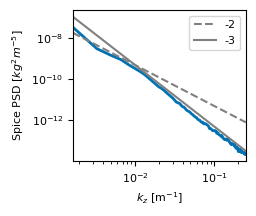

In [82]:
plt.figure(figsize=(2.6,2.2))
m = spice_2d_ps.freq_Pmean
dom = spice_2d_ps.freq_days.diff('freq_days').mean()

(spice_2d_ps.mean(['Pmean_segment', 'days_segment']).sum('freq_days')*dom).plot(linewidth=2.)

plt.plot(m, 5e-14*m**-2, '--', color='gray', label='-2')
plt.plot(m, 5e-16*m**-3, '-', color='gray', label='-3')

plt.xscale('log')
plt.xlim([1, 1/4])
plt.yscale('log')
#plt.ylim([1e-3, 4/24])

plt.xlabel('$k_z$ [m$^{-1}$]')
plt.ylabel('Spice PSD $[kg^2 m^{-5}]$')
plt.legend()
plt.tight_layout()

plt.savefig('./figures/2D_spectra/spice_psd_om_kz_avg_om.pdf')

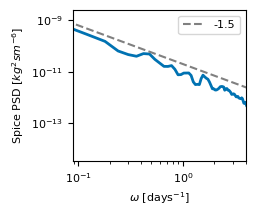

In [91]:
plt.figure(figsize=(2.6,2.2))

k = spice_2d_ps.freq_days

dm = spice_2d_ps.freq_Pmean.diff('freq_Pmean').mean()

(spice_2d_ps.mean(['Pmean_segment', 'days_segment']).sum('freq_Pmean')*dm).plot(linewidth=2)

plt.plot(k, 2e-11*k**-1.5, '--', color='gray', label='-1.5')
#plt.plot(m, 2e-17*m**-3)

plt.xscale('log')
#plt.xlim([1e-2, 10])
plt.yscale('log')
#plt.ylim([1e-3, 4/24])
plt.xlim([8/90, 24/6])


plt.xlabel('$\omega$ [days$^{-1}$]')
plt.ylabel('Spice PSD $[kg^2 s m^{-6}]$')
plt.tight_layout()
plt.legend()

plt.savefig('./figures/2D_spectra/spice_psd_om_kz_avg_kz.pdf')

### Horizontal-vertical 2D wavenumber spectrum over the striaght section

In [48]:
# select straight section
ds_660_scX = ds_660_rho.sel(dives=slice(225, 337))#.sel(ctd_pressure=500, method='nearest')
ds_659_scX = ds_659_rho.sel(dives=slice(182, 287))#.sel(ctd_pressure=500, method='nearest')

In [50]:
def interp_distance(ds, var): 
    #dist_grid = np.arange(20e3, 475e3, 500)
    dist_grid = np.arange(0, 416e3, 500)
    
    for i in range(len(ds.rho_grid)): 
        ds_temp = ds.isel(rho_grid=i)
        
        
        #distance = np.cumsum(gt.utils.distance(np.insert(ds_temp.longitude, 0, 33), 
        #                                       np.insert(ds_temp.latitude, 0, -50)))
        #data = np.insert(ds_temp[var].values, 0 , 0)
                           
        distance = np.cumsum(gt.utils.distance(ds_temp.longitude, ds_temp.latitude)) 
        data = ds_temp[var].values
        f = interpolate.interp1d(distance, data)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, "rho_grid": ds_temp.rho_grid}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='rho_grid')
        
    return da_var_int
            

In [51]:
ds_659_dist_sec = xr.merge( [interp_distance(ds_659_scX, 'Spice')] )
ds_660_dist_sec = xr.merge( [interp_distance(ds_660_scX, 'Spice')] )

In [52]:
# Function that regrids a single dive 
# Will be rung in a loop to do interpolation for all dives.

def func_var_int_pmean_dist(ds, Pmean_smooth_time): 
    Pmean_grid = np.linspace(0,1000,501)
    
    Pmean = Pmean_smooth_time
 
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    Pmean_nonan = Pmean.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'distance'],
                        coords = {'Pmean': Pmean_grid, 'distance': [ds.distance.values]})
    

In [55]:
# For 659
time_ind = 0

Pmean_smooth_time = ds_659_time.ctd_pressure.mean('days').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.69))
# use the same Pmean as what we got from time because it is smoother.
spice_on_Pmean_659_sec = func_var_int_pmean_dist(ds_659_dist_sec.Spice.isel(distance=0), 
                                            Pmean_smooth_time)

for dist_ind in range(1, len(ds_659_dist_sec.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_659_sec = xr.concat([spice_on_Pmean_659_sec, 
                                func_var_int_pmean_dist(ds_659_dist_sec.Spice.isel(distance=dist_ind), 
                                                   Pmean_smooth_time)],
                                dim='distance')

400
800


In [56]:
# For 660 
time_ind = 0

Pmean_smooth_time = ds_660_time.ctd_pressure.mean('days').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.69))
# use the same Pmean as what we got from time because it is smoother.
spice_on_Pmean_660_sec = func_var_int_pmean_dist(ds_660_dist_sec.Spice.isel(distance=0), 
                                            Pmean_smooth_time)

for dist_ind in range(1, len(ds_660_dist_sec.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_660_sec = xr.concat([spice_on_Pmean_660_sec, 
                                func_var_int_pmean_dist(ds_660_dist_sec.Spice.isel(distance=dist_ind), 
                                                   Pmean_smooth_time)],
                                dim='distance')

400
800


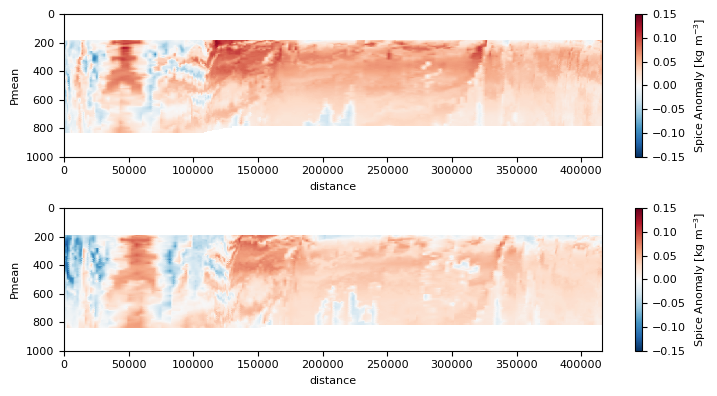

In [57]:
plt.figure(figsize=(7.5,4.))


plt.subplot(211)
(1000*spice_on_Pmean_659_sec).plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.gca().invert_yaxis()

#plt.ylim([800, 180]) # this is the range that is not super influenced by interplation.

plt.subplot(212)
(1000*spice_on_Pmean_660_sec).plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.gca().invert_yaxis()

plt.tight_layout()

In [58]:
spice_659_2d_ps_sec =xrft.power_spectrum(spice_on_Pmean_659_sec.sel(Pmean=slice(200, 800)
                                    ).isel(distance=slice(0,830)).chunk({'distance':166}), dim=['Pmean', 'distance'],
                                window=True, chunks_to_segments=True)

spice_660_2d_ps_sec =xrft.power_spectrum(spice_on_Pmean_660_sec.sel(Pmean=slice(200, 800)
                                    ).isel(distance=slice(0,830)).chunk({'distance':166}), dim=['Pmean', 'distance'],
                                window=True, chunks_to_segments=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [59]:
spice_2d_ps_sec = 0.5*(spice_659_2d_ps_sec + spice_660_2d_ps_sec)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/plot/plot.py:1426: UserWarning: Log scale: values of z <= 0 have been masked
  primitive = ax.contourf(x, y, z, **kwargs)


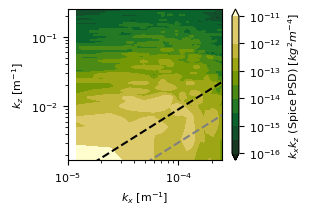

In [93]:
plt.figure(figsize=(3.1, 2.2))

m = spice_2d_ps_sec.freq_Pmean
k = spice_2d_ps_sec.freq_distance

lev_exp = np.linspace(-16, -11, 11)
levs = np.power(10, lev_exp)

cnt = (np.abs(m)*np.abs(k)*spice_2d_ps_sec.mean(['Pmean_segment', 'distance_segment'])).plot.contourf(
                        levels=levs,
                      norm=colors.LogNorm(vmin=1e-16),
                        cmap=cmo.speed_r, 
                     cbar_kwargs={'label':'$k_x  k_z  $ (Spice PSD) $[kg^2 m^{-4}]$'})

for c in cnt.collections:
    c.set_edgecolor("face")
    
    
plt.plot(k,30*k, '--', color='gray')
plt.plot(k,90*k, '--', color='black')

plt.xscale('log')
plt.xlim([1e-5, 1/4e3])

plt.yscale('log')
plt.ylim([1/600, 1/4])
#plt.grid()
plt.xlabel('$k_x$ [m$^{-1}$]')
plt.ylabel('$k_z$ [m$^{-1}$]')
plt.tight_layout()
#plt.title('Variance Preserving PSD')
plt.savefig('./figures/2D_spectra/spice_psd_kx_kz.pdf')

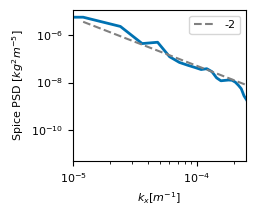

In [92]:
plt.figure(figsize=(2.6,2.2))

k = spice_2d_ps_sec.freq_distance

dk_z = spice_2d_ps_sec.freq_Pmean.diff('freq_Pmean').mean()


(spice_2d_ps_sec.mean(['Pmean_segment', 'distance_segment']).sum('freq_Pmean')*dk_z).plot(linewidth=2.)
#(spice_2d_ps_sec.mean(['Pmean_segment', 'distance_segment']).mean('freq_Pmean')).plot()
plt.plot(k, 5e-16*k**-2, '--', color='gray', label='-2')
#plt.plot(m, 2e-17*m**-3)

plt.xlabel('$k_x [m^{-1}$]')

plt.ylabel('Spice PSD [$kg^2 m^{-5}$]')

plt.legend()
plt.xscale('log')
plt.xlim([1e-5, 1/4e3])
plt.yscale('log')
#plt.ylim([1e-3, 4/24])

plt.tight_layout()
plt.savefig('./figures/2D_spectra/spice_psd_kx_kz_avg_kz.pdf')